In [20]:
pip install ripser

Note: you may need to restart the kernel to use updated packages.


In [21]:
# load some packages
from matplotlib.text import Text
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from ripser import ripser
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

In [22]:
pd.read_csv(
        'https://www.dropbox.com/scl/fi/jvtraplx4to7r5y3zzq4x/collaborations_Mathematical-Physics_105.csv.gz?rlkey=zfwbarxtgk8mm39rq8wz084ma&st=uagb53zy&dl=1',
        compression='gzip',
    )

,article_id,year,researcher_id
0,pub.1058197409,2001,ur.011354531601.87
1,pub.1058197409,2001,ur.011663011361.49
2,pub.1058194732,1981,ur.010165172102.13
3,pub.1058194732,1981,ur.012356227236.62
4,pub.1058194732,1981,ur.014467670703.92
...,...,...,...
693622,pub.1104998165,2018,ur.0732233414.25
693623,pub.1033208781,2002,ur.011170022015.06
693624,pub.1092523788,2017,ur.010122671761.59
693625,pub.1092523788,2017,ur.013642004376.72


In [23]:
pd.read_csv(
        'https://www.dropbox.com/scl/fi/4xf8k1qkqqhf0obgfntug/articles_Mathematical-Physics_105.csv.gz?rlkey=ry94p2lk666900ph12uf4xn4p&st=ujpgk5rh&dl=1',
        compression = 'gzip',
    ).columns

/var/folders/v9/_js75nzx64lf8__fmfsscg4c0000gn/T/ipykernel_17898/1696472445.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(


Index(['article_id', 'year', 'date', 'doi', 'volume', 'issue', 'pages',
       'title_preferred', 'abstract_preferred', 'journal_title',
       'citations_count', 'metrics_times_cited', 'metrics_recent_citations',
       'metrics_field_citation_ratio', 'metrics_relative_citation_ratio',
       'altmetrics_score', 'nauthors', 'npatents_citing',
       'ncategory_for_l1_codes', 'ncategory_for_l2_codes',
       'pg_abstract_preferred_lang_code', 'pg_abstract_preferred_lang_conf'],
      dtype='object')

In [24]:
# load the data
df = pd.read_csv(
        'https://www.dropbox.com/scl/fi/e63x0g4hl7s9se21nwk3w/concepts_Mathematical-Physics_105.csv.gz?rlkey=pwy1yrazk98a6e7y68sxsvytm&st=sv7vnrmr&dl=1',
        compression='gzip',
    )

df

,article_id,year,concept,relevance_mean,concept_freq_in_abstract,concept_no,dfreq_in_category_for_2l,dfreq_in_category_for_2l_year
0,pub.1058195248,1984,aramovich aleksandryan,0.0,1,0,1,1
1,pub.1124025572,2015,bond percolation threshold conjecture,0.0,1,0,1,1
2,pub.1072369703,2001,international summer school conference,0.0,1,0,1,1
3,pub.1058195137,1983,moiseevich gel fand,0.0,1,0,2,1
4,pub.1058196788,1996,petrovich mityuk,0.0,1,0,2,2
...,...,...,...,...,...,...,...,...
3522087,pub.1091413712,2018,’s western region market,0.0,1,82,1,1
3522088,pub.1129362014,2020,’s window function w,0.0,1,68,1,1
3522089,pub.1052337841,1997,’ σ model space,0.0,1,68,1,1
3522090,pub.1123343675,2020,′ r 0 ′,0.0,1,72,1,1


In [25]:
# config
MIN_RELEVANCE = 0.7
MIN_YEAR = 1920
MAX_YEAR = 2021  # when the data is from
MIN_CONCEPT_FREQ = 0.0001
MAX_CONCEPT_FREQ = 0.001

# relevance filtering
df = df[df['relevance_mean'] >= MIN_RELEVANCE]

# year filtering
df = df[df['year'] >= MIN_YEAR]

# counts
num_articles = df['article_id'].nunique()
concept_freq = df.groupby('concept').transform('size') / num_articles
df = df[(concept_freq >= MIN_CONCEPT_FREQ) & (concept_freq <= MAX_CONCEPT_FREQ)]

# remove columns we dont care about
df = df[['article_id', 'concept', 'year']]

df

,article_id,concept,year
556,pub.1006732552,a c magnetic field,2003
1051,pub.1002749612,ab interface,2004
1695,pub.1045174311,adhm datum,2015
1834,pub.1127359864,ae event,2020
1845,pub.1113308773,ae signal,2019
...,...,...,...
3518015,pub.1044797849,γp colliders,1994
3520805,pub.1042370694,φ4 quantum field theory,1995
3520808,pub.1020813233,φ4 scalar field theory,1977
3521318,pub.1109913000,ϕ4 field theory,2018


In [26]:
# get the initial publication
concepts = (
        df
            .sort_values('year')  # sort so earliest year is first
            .groupby('concept')
            .agg(
                year=('year', 'min'),
                count=('article_id', 'nunique')
            )
            .reset_index()
    )

# normalize the year
concepts['norm_year'] = (concepts['year'] - MIN_YEAR) / (MAX_YEAR - MIN_YEAR)

concepts

,concept,year,count,norm_year
0,a c magnetic field,2003,1,0.821782
1,ab initio calculation,2019,1,0.980198
2,ab initio molecular dynamic,2016,1,0.950495
3,ab initio molecular dynamic method,2015,1,0.940594
4,ab interface,2004,1,0.831683
...,...,...,...,...
18497,zro2 nanoparticle,2011,1,0.900990
18498,γp colliders,1994,1,0.732673
18499,φ4 quantum field theory,1995,1,0.742574
18500,φ4 scalar field theory,1977,1,0.564356


In [27]:
# get all possible edges
edges = df.merge(df, on=['article_id', 'year'], suffixes=['_source', '_target'])

# remove duplicates
edges = edges[edges['concept_source'] < edges['concept_target']]  # remove self links (u - u) and the second occurance (u - v vs v - u)
# edges = edges.sort_values('year').drop_duplicates(subset=['concept_source', 'concept_target']).reset_index(drop=True)
edges = edges.groupby(['concept_source', 'concept_target']).agg(
        year=('year', 'min'),
        count=('article_id', 'nunique')
    ).reset_index()

# nromalize the year
edges['norm_year'] = (edges['year'] - MIN_YEAR) / (MAX_YEAR - MIN_YEAR)

edges

,concept_source,concept_target,year,count,norm_year
0,a c magnetic field,ac field,2003,1,0.821782
1,a c magnetic field,collective motion,2003,1,0.821782
2,a c magnetic field,dc magnetic field,2003,1,0.821782
3,a c magnetic field,excitation mode,2003,1,0.821782
4,a c magnetic field,microwave dissipation,2003,1,0.821782
...,...,...,...,...,...
49230,wind power,wind turbine,2013,1,0.920792
49231,wn algebra,yang baxter relation,1997,1,0.762376
49232,write capacity,write performance,2017,1,0.960396
49233,yang mills field,zakharov shabat system,2010,1,0.891089


# Co-occurance statisitc

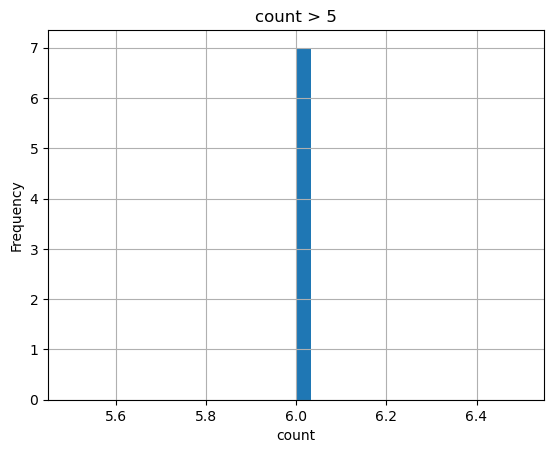

In [28]:
subset = edges[edges['count'] > 5]
subset['count'].hist(bins=30)
plt.xlabel('count')
plt.ylabel('Frequency')
plt.title('count > 5')
plt.show()

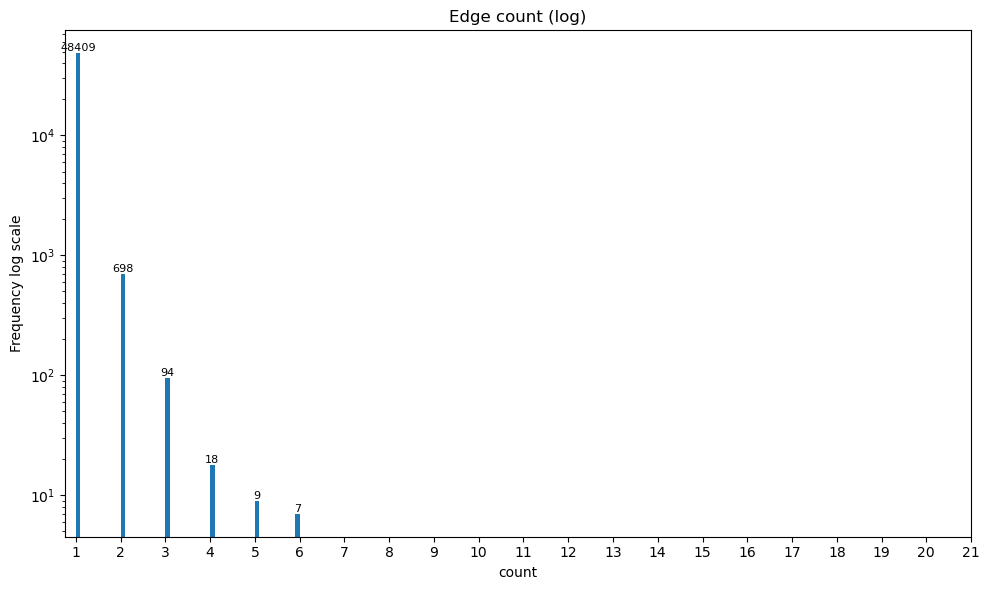

In [29]:
counts, bins = np.histogram(edges['count'], bins=50)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, counts, width=(bins[1] - bins[0]))
plt.yscale('log')
plt.xlabel('count')
plt.ylabel('Frequency log scale')
plt.title('Edge count (log)')
for x, y in zip(bin_centers, counts):
    if y > 0:
        plt.text(x, y, str(y), ha='center', va='bottom', fontsize=8)
plt.xticks(np.arange(1, 22, 1))
plt.tight_layout()
plt.show()

In [30]:
import oat_python as oat

In [31]:
def createsubgraph(edges, n):
    edges_single = edges[edges['count'] >= n]
    concepts_used = set(edges_single['concept_source']) | set(edges_single['concept_target'])
    concepts_sub = concepts[concepts['concept'].isin(concepts_used)]

    G_sub = nx.Graph()

    G_sub.add_nodes_from([
        (c, {'norm_year': ny, 'count': ic}) 
        for c, ny, ic in zip(concepts_sub['concept'], concepts_sub['norm_year'], concepts_sub['count'])
    ])

    G_sub.add_edges_from([
        (u, v, {'norm_year': ny, 'count': ic}) 
        for u, v, ny, ic in zip(edges_single['concept_source'], edges_single['concept_target'],
                                edges_single['norm_year'], edges_single['count'])
    ])
    return G_sub

G_sub1 = createsubgraph(edges,1)
G_sub2 = createsubgraph(edges,2)
G_sub3 = createsubgraph(edges,3)
G_sub4 = createsubgraph(edges,4)

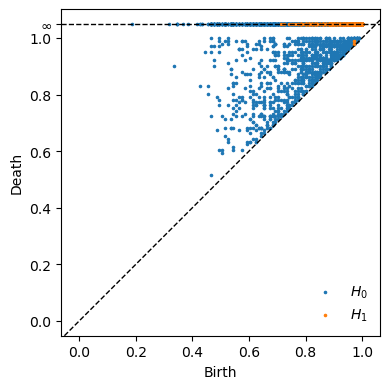

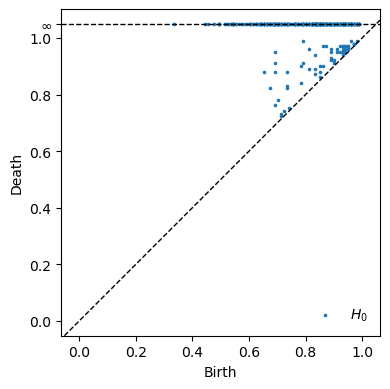

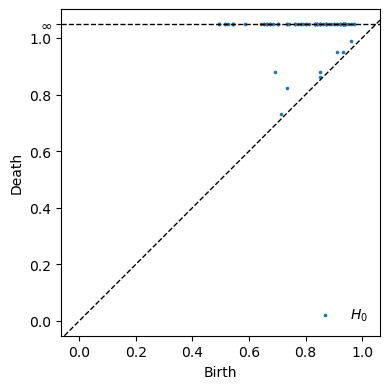

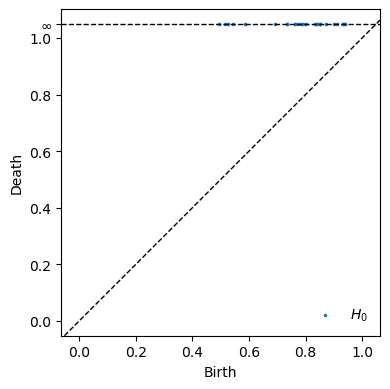

In [32]:
def gethomology(G_sub):
    node_list = list(G_sub.nodes) 
    node_index = {i: node_list[i] for i in range(len(node_list))}   
    reverse_index = {v: k for k, v in node_index.items()}           

    adj = nx.adjacency_matrix(G_sub, nodelist=node_list, weight='norm_year')
    adj.setdiag([G_sub.nodes[n]['norm_year'] for n in node_list])
    adj = adj.sorted_indices()

    factored = oat.rust.FactoredBoundaryMatrixVr(adj, 1)
    homology = factored.homology(
        return_cycle_representatives=True,
        return_bounding_chains=True
    )

    return homology, node_index 

def draw_persistent_diag(G_sub):
    homology,node = gethomology(G_sub)
    # initialize the plot
    fig, ax = plt.subplots()
    fig.set_figheight(4)
    fig.set_figwidth(4)
    infty = 1.05
    ax.set_xlabel('Birth')
    ax.set_ylabel('Death')
    ax.axis('equal')

    # lines
    ax.axhline(infty, ls='--', c='k', lw=1)
    ax.axline([0, 0], [1, 1], ls='--', c='k', lw=1)

    # loop, plot homology
    for dim in homology['dimension'].unique():
        dim_bc = homology[homology['dimension'] == dim]
        ax.scatter(dim_bc['birth'], dim_bc['death'].replace(np.inf, infty), s=2.5, label=f'$H_{dim}$')

    # final formatting
    ticks = ax.get_yticklabels()[1:-1]
    ticks.append(Text(0, infty, r'$\infty$'))  # add infty label
    ax.set_yticks(np.hstack((ax.get_yticks()[1:-1], infty)))
    ax.set_yticklabels(ticks)
    ax.legend(frameon=False)
    fig.tight_layout()

draw_persistent_diag(G_sub1)
draw_persistent_diag(G_sub2)
draw_persistent_diag(G_sub3)
draw_persistent_diag(G_sub4)

In [33]:
import ast
import re

In [34]:
df_homology1 = gethomology(G_sub1)
df_homology2 = gethomology(G_sub2)
df_homology3 = gethomology(G_sub3)
df_homology4 = gethomology(G_sub4)

def picklargestcycle(df_homology, node_index, max_filtration_val=1.05):
    df_H1 = df_homology[df_homology['dimension'] == 1].copy()
    df_H1['death_mod'] = df_H1['death'].replace(np.inf, max_filtration_val)
    df_H1['persistence'] = df_H1['death_mod'] - df_H1['birth']

    df_H1_sorted = df_H1.sort_values(by=['persistence', 'birth'], ascending=[False, True])
    target_bar = df_H1_sorted.iloc[0]
    print(f"Selected bar: birth={target_bar['birth']}, death={target_bar['death']}, persistence={target_bar['persistence']}")

    pattern_all = r"\[([0-9,\s]+)\]"
    matches = re.findall(pattern_all, str(target_bar['cycle representative']))

    edge_list = []
    for m in matches:
        local_nodes = list(map(int, m.strip().split(',')))
        real_nodes = [node_index[i] for i in local_nodes]  # 恢复原始 concept ID
        if len(real_nodes) == 2:
            edge_list.append(tuple(real_nodes))
        elif len(real_nodes) > 2:
            edge_list.extend([(real_nodes[i], real_nodes[(i+1)%len(real_nodes)]) for i in range(len(real_nodes))])

    node_set = set([n for edge in edge_list for n in edge])
    print("Nodes involved in generator:", node_set)
    print("Edges:", edge_list)

    return node_set, edge_list

Selected bar: birth=0.7128712871287128, death=inf, persistence=0.3371287128712872
Nodes involved in generator: {'conformal invariant theory', 'different scaling limit', 'vertex model', 'continuous limit', 'simons gauge theory', 'six vertex model', 'light cone lattice approach', 'two dimensional statistical mechanic', 'light cone approach'}
Edges: [('light cone approach', 'six vertex model'), ('continuous limit', 'two dimensional statistical mechanic'), ('continuous limit', 'six vertex model'), ('simons gauge theory', 'vertex model'), ('simons gauge theory', 'two dimensional statistical mechanic'), ('conformal invariant theory', 'vertex model'), ('conformal invariant theory', 'light cone lattice approach'), ('different scaling limit', 'light cone lattice approach'), ('different scaling limit', 'light cone approach')]


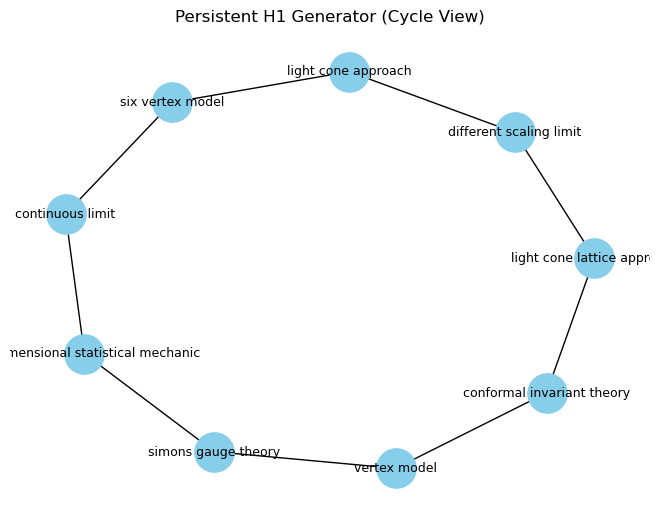

IndexError: single positional indexer is out-of-bounds

In [36]:
def drawlargecycle(df_homology, node_index, G_sub, max_filtration_val=1.05, show_labels=True):
    node_set, edge_list = picklargestcycle(df_homology, node_index, max_filtration_val)
    H = nx.Graph()
    H.add_nodes_from(node_set)
    H.add_edges_from(edge_list)
    pos = nx.spring_layout(H, seed=42)

    if show_labels:
        labels = {
            n: G_sub.nodes[n]['label'] if 'label' in G_sub.nodes[n] else str(n)
            for n in H.nodes
        }
    else:
        labels = None
    nx.draw(H, pos, with_labels=show_labels, labels=labels,
            node_color='skyblue', node_size=800, font_size=9)
    
    plt.title("Persistent H1 Generator (Cycle View)")
    plt.axis('off')
    plt.show()

df_homology1, node_index1 = gethomology(G_sub1)
df_homology2, node_index2 = gethomology(G_sub2)
df_homology3, node_index3 = gethomology(G_sub3)
df_homology4, node_index4 = gethomology(G_sub4)
drawlargecycle(df_homology1, node_index1, G_sub1)
#drawlargecycle(df_homology2, node_index2, G_sub2)
drawlargecycle(df_homology3, node_index3, G_sub3)
drawlargecycle(df_homology4, node_index4, G_sub4)